In [1]:
%pip install 'stable-baselines3[extra]' -q

Note: you may need to restart the kernel to use updated packages.


## Playing with OpenAI Gymnassium

In [2]:
import os
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [3]:
playground_config = "CartPole-v1"
playground = gym.make(playground_config, render_mode="rgb_array")

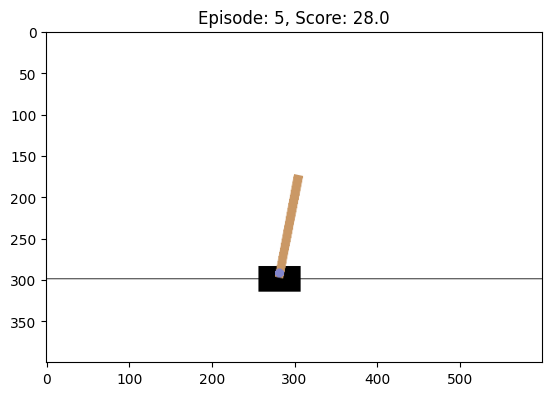

In [4]:
episodes = 5
playground.reset()
img = plt.imshow(playground.render()) 
for episode in range(episodes):
    state = playground.reset()
    done = False
    score = 0
    while not done:
        img.set_data(playground.render())
        action = playground.action_space.sample()
        obs, reward, terminated, truncated , info = playground.step(action)
        done = terminated or truncated
        score += reward
        title_box = (f"Episode: {episode + 1}, Score: {score}")
        plt.title(title_box)
        display.display(plt.gcf())
        display.clear_output(wait=True)
playground.close()

In [5]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


## Training the Playground Model

In [6]:

logpath = "training/logs"
os.makedirs(logpath, exist_ok=True)

In [7]:
# Check if Apple MPS or Nvidia CUDA is available on PyTorch

import torch

if torch.backends.mps.is_available():
    print("MPS backend is available. Setting to Apple MPS.")
    torch.device("mps")
elif torch.cuda.is_available():
    print("Nvidia CUDA is available. Setting to CUDA.")
    torch.device("cuda")
else:
    print("MPS backend or CUDA is not available.")

MPS backend is available. Setting to Apple MPS.


In [8]:
playground = gym.make(playground_config)
playground = DummyVecEnv([lambda: playground])
model = PPO("MlpPolicy", playground, verbose=1, tensorboard_log=logpath)
# Issue with Apple M Series, even though it uses Metal, it displays CPU

Using cpu device


In [9]:
# First Train the Model
model.learn(total_timesteps=50000)

# Save the Model
os.makedirs("training/models", exist_ok=True)
model.save("training/models/ppo_cartpole")

print("Model has been saved.")

Logging to training/logs/PPO_4
-----------------------------
| time/              |      |
|    fps             | 7042 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 4533        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009366827 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | -0.00555    |
|    learning_rate        | 0.0003      |
|    loss                 | 6.17        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0193     |
|    value_loss           | 50.9        |
-----------------------------------------
---

In [10]:
# Load from the Model
loaded_model = PPO.load("training/models/ppo_cartpole",env=playground)

In [11]:
# Evaluate the Model
mean_reward, std_reward = evaluate_policy(loaded_model, playground, n_eval_episodes=10,render=False)
print(f"Mean Reward: {mean_reward:.2f} +/- {std_reward:.2f}")

/Users/mohamedkamran/Developer/study/reinforcement-learning/.conda/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean Reward: 500.00 +/- 0.00


In [12]:
# Test the Model
episodes = 5
playground = gym.make(playground_config, render_mode="rgb_array")
playground = DummyVecEnv([lambda: playground])
for episode in range(episodes):
    state = playground.reset()
    done = False
    score = 0
    while not done:
        action, _ = loaded_model.predict(state)
        state, reward, done, info = playground.step(action)
        score += reward
        title_box = (f"Episode: {episode + 1}, Score: {score}")
        # plt.title(title_box)
        # display.display(plt.gcf())
        # display.clear_output(wait=True)
    print(f"Episode: {episode + 1}, Score: {score}")
playground.close()

Episode: 1, Score: [500.]
Episode: 2, Score: [500.]
Episode: 3, Score: [500.]
Episode: 4, Score: [500.]
Episode: 5, Score: [500.]


In [13]:
state

array([[-0.00903563, -0.03876719,  0.01503235,  0.02104246]],
      dtype=float32)

In [14]:
"Tensorboard can be used to visualize the training process."
# training_ppo5 = os.path.join(logpath, "PPO_6")
# !tensorboard --logdir={training_ppo5}

'Tensorboard can be used to visualize the training process.'

## Change the Architectures of the Model

In [15]:
# Extend the Training
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=200, verbose=1)
eval_callback = EvalCallback(playground, callback_on_new_best=stop_callback, eval_freq=100000, best_model_save_path="training/models/ppo_cartpole_best", verbose=1)

In [16]:
model = PPO("MlpPolicy", playground, verbose=1, tensorboard_log=logpath)
model.learn(total_timesteps=200000, callback=eval_callback)

Using cpu device
Logging to training/logs/PPO_5
-----------------------------
| time/              |      |
|    fps             | 6173 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 4241        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008019242 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | 0.0016      |
|    learning_rate        | 0.0003      |
|    loss                 | 4.18        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0139     |
|    value_loss           | 47.2        |
----------------------------

In [17]:
# Change Policy Network Architecture
net_arch = [dict(pi=[128,128,128,128], vf=[128,128,128,128])]
model = PPO("MlpPolicy", playground, policy_kwargs=dict(net_arch=net_arch), verbose=1, tensorboard_log=logpath)
model.learn(total_timesteps=100000, callback=eval_callback)

Using cpu device
Logging to training/logs/PPO_6


/Users/mohamedkamran/Developer/study/reinforcement-learning/.conda/lib/python3.11/site-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 5198 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3110        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016603768 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    explained_variance   | -0.000402   |
|    learning_rate        | 0.0003      |
|    loss                 | 2.08        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0246     |
|    value_loss           | 15.7        |
-----------------------------------------
----------------------------------

In [ ]:
# Use Alternate Algorithms
from stable_baselines3 import DQN
model = DQN("MlpPolicy", playground, verbose=1, tensorboard_log=logpath)
model.learn(total_timesteps=100000)

Using cpu device
Logging to training/logs/DQN_2
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 7576     |
|    time_elapsed     | 0        |
|    total_timesteps  | 63       |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4429     |
|    time_elapsed     | 0        |
|    total_timesteps  | 150      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 12       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 4349     |
|    time_elapsed     | 0        |
|    total_timesteps  | 233      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.51     |
|    n_updates        | 33       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rat